In [1]:
from __future__ import division, print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
#In [2]:
DATA_DIR = ""
IMAGE_DIR = os.path.join(DATA_DIR, "new_test_folder")

In [3]:
# image_dir = 'new_test_folder'
file_name = []
dfcols = ['img_name']
df = pd.DataFrame(columns=dfcols)

for img_file in os.listdir(IMAGE_DIR):
    if img_file.find(".jpg") != -1:
        df = df.append(pd.Series([img_file], index=dfcols),
                            ignore_index=True) 
df = df.sort_values("img_name", ascending=True)
df = df.reset_index(drop=True)
df.to_csv('all.csv', encoding='utf-8', index=False)

In [4]:
print(len(df))

628


In [5]:
group1 = ['0001', '0002', '0003']
# group2 = ['0006', '0007', '0008', '0009']
mlabel = ''
all_triples = []
triples = []
for index_1, row_1 in df.iterrows():
    for index_2, row_2 in df.iterrows():
        if index_2 > index_1:
            if row_1['img_name'][2:6] in group1:
                mg_l = '1'
            else:
                mg_l = '2'
            if row_2['img_name'][2:6] in group1:
                mg_r = '1'
            else:
                mg_r = '2'
            mlabel = '0'
            triples = []
            if (row_1['img_name'][0:2] == row_2['img_name'][0:2] and mg_l == '2' and mg_r == '2') :   
                mlabel = '1'
                triples = [row_1['img_name'],row_2['img_name'],mlabel]
#             if (row_1['img_name'][0:2] != row_2['img_name'][0:2] and mg_l == '2' and mg_r == '2') :   
#                 mlabel = '0'
#                 triples = [row_1['img_name'],row_2['img_name'],mlabel]
            if (row_1['img_name'][0:2] == row_2['img_name'][0:2] and mg_l != mg_r ) :   
                mlabel = '0'
                triples = [row_1['img_name'],row_2['img_name'],mlabel]
            if len(triples) != 0 :    
                all_triples.append(triples)

In [6]:
print(len(all_triples))

4469


In [7]:
'''
#In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if group_name in image_groups:
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples
'''    

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "r")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def preprocess_data(vector_file, train_size=0.7):
    xdata, ydata = [], []
    vec_dict = load_vectors(vector_file)
    for image_triple in all_triples:
        X1 = vec_dict[image_triple[0]]
        X2 = vec_dict[image_triple[1]]
        xdata.append(np.multiply(X1, X2) / (np.linalg.norm(X1, 2) * np.linalg.norm(X2, 2)))
        ydata.append(image_triple[2])
    X, y = np.array(xdata), np.array(ydata)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    return Xtrain, Xtest, ytrain, ytest

def cross_validate(X, y, clf, k=10):
    best_score, best_clf = 0.0, None
    kfold = KFold(k)
    for kid, (train, test) in enumerate(kfold.split(X, y)):
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        clf.fit(Xtrain, ytrain)
        ytest_ = clf.predict(Xtest)
        score = accuracy_score(ytest_, ytest)
        print("fold {:d}, score: {:.3f}".format(kid, score))
        if score > best_score:
            best_score = score
            best_clf = clf
    return best_clf, best_score

def test_report(clf, Xtest, ytest):
    ytest_ = clf.predict(Xtest)
    print("\nAccuracy Score: {:.3f}".format(accuracy_score(ytest_, ytest)))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytest_, ytest))
    print("\nClassification Report")
    print(classification_report(ytest_, ytest))
    
def get_model_file(data_dir, vec_name, clf_name):
    return os.path.join(data_dir, "weights", "A-{:s}-{:s}-dot-v2.pkl"
                        .format(vec_name, clf_name))

def save_model(model, model_file):
    joblib.dump(model, model_file)

In [8]:
#In [4]:
image_triples = all_triples # get_holiday_triples(IMAGE_DIR)

In [9]:
#In [5]:
NUM_VECTORIZERS = 5
NUM_CLASSIFIERS = 4
scores = np.zeros((NUM_VECTORIZERS, NUM_CLASSIFIERS))

In [10]:
#In [6]:
VECTOR_FILE = os.path.join(DATA_DIR, "weights", "accton-vgg16-vectors-v2.tsv")
print(VECTOR_FILE)
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

weights/accton-vgg16-vectors-v2.tsv
(3128, 4096) (1341, 4096) (3128,) (1341,)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
#In [7]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "nb")) # Accuracy Score: 0.888
'''
Confusion Matrix
[[381 120]
 [ 30 810]]
'''
#In [8]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "svm")) # Accuracy Score: 0.676
'''
Confusion Matrix
[[  0   0]
 [411 930]]
'''
#In [9]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "xgb")) # Accuracy Score: 1.000
'''
Confusion Matrix
[[435   0]
 [  0 906]]
'''
#In [10]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "rf")) # Accuracy Score: 0.996
'''
Confusion Matrix
[[430   1]
 [  5 905]]
'''

fold 0, score: 0.863
fold 1, score: 0.904
fold 2, score: 0.895
fold 3, score: 0.882
fold 4, score: 0.936
fold 5, score: 0.888
fold 6, score: 0.911
fold 7, score: 0.914
fold 8, score: 0.885
fold 9, score: 0.881

Accuracy Score: 0.887

Confusion Matrix
[[392 121]
 [ 31 797]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.76      0.84       513
          1       0.87      0.96      0.91       828

avg / total       0.89      0.89      0.88      1341

fold 0, score: 0.741
fold 1, score: 0.674
fold 2, score: 0.633
fold 3, score: 0.693
fold 4, score: 0.668
fold 5, score: 0.658
fold 6, score: 0.671
fold 7, score: 0.674
fold 8, score: 0.689
fold 9, score: 0.696

Accuracy Score: 0.685

Confusion Matrix
[[  0   0]
 [423 918]]

Classification Report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.68      0.81      1341

avg / total       1.00      0.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.997

Accuracy Score: 0.993

Confusion Matrix
[[422   9]
 [  1 909]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.98      0.99       431
          1       0.99      1.00      0.99       910

avg / total       0.99      0.99      0.99      1341

fold 0, score: 0.987
fold 1, score: 0.994
fold 2, score: 0.990
fold 3, score: 0.990
fold 4, score: 0.987
fold 5, score: 0.994
fold 6, score: 0.984
fold 7, score: 0.987
fold 8, score: 0.990
fold 9, score: 0.987

Accuracy Score: 0.990

Confusion Matrix
[[421  12]
 [  2 906]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.97      0.98       433
          1       0.99      1.00      0.99       908

avg / total       0.99      0.99      0.99      1341



'\nConfusion Matrix\n[[430   1]\n [  5 905]]\n'

In [12]:
#In [11]:
VECTOR_FILE = os.path.join(DATA_DIR, "weights", "accton-vgg19-vectors-v2.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#In [12]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "nb")) # Accuracy Score: 0.893
'''
Confusion Matrix
[[370 114]
 [ 30 827]]
'''
#In [13]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "svm")) # Accuracy Score: 0.702
'''
Confusion Matrix
[[  0   0]
 [400 941]]
'''
#In [14]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "xgb")) # Accuracy Score: 0.996
'''
Confusion Matrix
[[397   2]
 [  3 939]]
'''
#In [15]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "rf")) # Accuracy Score: 0.992
'''
Confusion Matrix
[[392   3]
 [  8 938]]
'''

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(3128, 4096) (1341, 4096) (3128,) (1341,)
fold 0, score: 0.856
fold 1, score: 0.875
fold 2, score: 0.872
fold 3, score: 0.885
fold 4, score: 0.901
fold 5, score: 0.885
fold 6, score: 0.904
fold 7, score: 0.914
fold 8, score: 0.894
fold 9, score: 0.901

Accuracy Score: 0.893

Confusion Matrix
[[370 114]
 [ 30 827]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.76      0.84       484
          1       0.88      0.96      0.92       857

avg / total       0.90      0.89      0.89      1341

fold 0, score: 0.665
fold 1, score: 0.674
fold 2, score: 0.684
fold 3, score: 0.668
fold 4, score: 0.658
fold 5, score: 0.700
fold 6, score: 0.665
fold 7, score: 0.668
fold 8, score: 0.667
fold 9, score: 0.676

Accuracy Score: 0.702

Confusion Matrix
[[  0   0]
 [400 941]]

Classification Report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.70      0.82

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.990


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 1.000

Accuracy Score: 0.996

Confusion Matrix
[[397   2]
 [  3 939]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       399
          1       1.00      1.00      1.00       942

avg / total       1.00      1.00      1.00      1341

fold 0, score: 1.000
fold 1, score: 0.987
fold 2, score: 0.994
fold 3, score: 0.997
fold 4, score: 0.987
fold 5, score: 0.971
fold 6, score: 0.994
fold 7, score: 0.990
fold 8, score: 0.990
fold 9, score: 0.997

Accuracy Score: 0.992

Confusion Matrix
[[392   3]
 [  8 938]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       395
          1       1.00      0.99      0.99       946

avg / total       0.99      0.99      0.99      1341



'\nConfusion Matrix\n[[418   8]\n [  7 908]]\n'

In [13]:
#In [16]:
VECTOR_FILE = os.path.join(DATA_DIR, "weights", "accton-inception-vectors-v2.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#In [17]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "nb")) # Accuracy Score: 0.860
'''
Confusion Matrix
[[413 164]
 [ 24 740]]
'''
#In [18]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "svm")) # Accuracy Score: 0.674
'''
Confusion Matrix
[[  0   0]
 [437 904]]
'''
#In [19]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "xgb")) # Accuracy Score: 0.996
'''
Confusion Matrix
[[418   1]
 [  5 917]]
'''
#In [20]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "rf")) # Accuracy Score: 0.987
'''
Confusion Matrix
[[428   9]
 [  9 895]]
'''

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(3128, 2048) (1341, 2048) (3128,) (1341,)
fold 0, score: 0.808
fold 1, score: 0.863
fold 2, score: 0.792
fold 3, score: 0.824
fold 4, score: 0.843
fold 5, score: 0.837
fold 6, score: 0.869
fold 7, score: 0.885
fold 8, score: 0.875
fold 9, score: 0.878

Accuracy Score: 0.860

Confusion Matrix
[[413 164]
 [ 24 740]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.72      0.81       577
          1       0.82      0.97      0.89       764

avg / total       0.87      0.86      0.86      1341

fold 0, score: 0.684
fold 1, score: 0.677
fold 2, score: 0.706
fold 3, score: 0.681
fold 4, score: 0.681
fold 5, score: 0.712
fold 6, score: 0.661
fold 7, score: 0.658
fold 8, score: 0.702
fold 9, score: 0.679

Accuracy Score: 0.674

Confusion Matrix
[[  0   0]
 [437 904]]

Classification Report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.67      0.81

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.990


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.990


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.990

Accuracy Score: 0.993

Confusion Matrix
[[430   2]
 [  7 902]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       432
          1       1.00      0.99      1.00       909

avg / total       0.99      0.99      0.99      1341

fold 0, score: 0.994
fold 1, score: 0.994
fold 2, score: 0.987
fold 3, score: 0.994
fold 4, score: 0.974
fold 5, score: 0.994
fold 6, score: 0.994
fold 7, score: 0.990
fold 8, score: 0.990
fold 9, score: 0.987

Accuracy Score: 0.987

Confusion Matrix
[[428   9]
 [  9 895]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       437
          1       0.99      0.99      0.99       904

avg / total       0.99      0.99      0.99      1341



'\nConfusion Matrix\n[[409   6]\n [ 14 912]]\n'

In [14]:
#In [21]:
VECTOR_FILE = os.path.join(DATA_DIR, "weights", "accton-resnet-vectors-v2.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#In [22]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "nb")) # Accuracy Score: 0.890
'''
Confusion Matrix
[[412 123]
 [ 25 781]]
'''
#In [23]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "svm")) # Accuracy Score: 0.694
'''
Confusion Matrix
[[ 31   1]
 [410 899]]
'''
#In [24]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "xgb")) # Accuracy Score: 0.987
'''
Confusion Matrix
[[420   1]
 [ 17 903]]
'''
#In [25]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "rf")) # Accuracy Score: 0.984
'''
Confusion Matrix
[[422   6]
 [ 15 898]]
'''

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(3128, 2048) (1341, 2048) (3128,) (1341,)
fold 0, score: 0.869
fold 1, score: 0.875
fold 2, score: 0.898
fold 3, score: 0.882
fold 4, score: 0.869
fold 5, score: 0.901
fold 6, score: 0.869
fold 7, score: 0.872
fold 8, score: 0.853
fold 9, score: 0.897

Accuracy Score: 0.890

Confusion Matrix
[[412 123]
 [ 25 781]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.77      0.85       535
          1       0.86      0.97      0.91       806

avg / total       0.90      0.89      0.89      1341

fold 0, score: 0.703
fold 1, score: 0.719
fold 2, score: 0.700
fold 3, score: 0.706
fold 4, score: 0.703
fold 5, score: 0.712
fold 6, score: 0.728
fold 7, score: 0.677
fold 8, score: 0.724
fold 9, score: 0.651

Accuracy Score: 0.688

Confusion Matrix
[[ 23   4]
 [414 900]]

Classification Report
             precision    recall  f1-score   support

          0       0.05      0.85      0.10        27
          1       1.00      0.68      0.81

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.984


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.981


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.981


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.990


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.984

Accuracy Score: 0.987

Confusion Matrix
[[420   1]
 [ 17 903]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       421
          1       1.00      0.98      0.99       920

avg / total       0.99      0.99      0.99      1341

fold 0, score: 0.987
fold 1, score: 0.997
fold 2, score: 0.990
fold 3, score: 0.984
fold 4, score: 0.984
fold 5, score: 0.974
fold 6, score: 0.994
fold 7, score: 0.984
fold 8, score: 0.994
fold 9, score: 0.990

Accuracy Score: 0.984

Confusion Matrix
[[422   6]
 [ 15 898]]

Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       428
          1       0.99      0.98      0.99       913

avg / total       0.98      0.98      0.98      1341



'\nConfusion Matrix\n[[449   9]\n [ 19 864]]\n'

In [15]:
#In [26]:
VECTOR_FILE = os.path.join(DATA_DIR, "weights", "accton-xception-vectors-v2.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#In [27]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "nb")) # Accuracy Score: 0.860
'''
Confusion Matrix
[[409 158]
 [ 30 744]]
'''
#In [28]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "svm")) # Accuracy Score: 0.699
'''
Confusion Matrix
[[  0   0]
 [404 937]]
'''
#In [29]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "xgb")) # Accuracy Score: 0.991
'''
Confusion Matrix
[[394   2]
 [ 10 935]]
'''
#In [30]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "rf")) # Accuracy Score: 0.995
'''
Confusion Matrix
[[402   5]
 [  2 932]]
''' 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(3128, 2048) (1341, 2048) (3128,) (1341,)
fold 0, score: 0.853
fold 1, score: 0.866
fold 2, score: 0.872
fold 3, score: 0.863
fold 4, score: 0.853
fold 5, score: 0.853
fold 6, score: 0.866
fold 7, score: 0.859
fold 8, score: 0.849
fold 9, score: 0.859

Accuracy Score: 0.852

Confusion Matrix
[[364 159]
 [ 40 778]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.70      0.79       523
          1       0.83      0.95      0.89       818

avg / total       0.86      0.85      0.85      1341

fold 0, score: 0.677
fold 1, score: 0.674
fold 2, score: 0.620
fold 3, score: 0.671
fold 4, score: 0.661
fold 5, score: 0.665
fold 6, score: 0.661
fold 7, score: 0.703
fold 8, score: 0.705
fold 9, score: 0.699

Accuracy Score: 0.699

Confusion Matrix
[[  0   0]
 [404 937]]

Classification Report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.70      0.82

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.981


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.997


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.994


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.997

Accuracy Score: 0.991

Confusion Matrix
[[394   2]
 [ 10 935]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       396
          1       1.00      0.99      0.99       945

avg / total       0.99      0.99      0.99      1341

fold 0, score: 1.000
fold 1, score: 0.990
fold 2, score: 0.994
fold 3, score: 0.987
fold 4, score: 0.994
fold 5, score: 0.994
fold 6, score: 0.990
fold 7, score: 0.990
fold 8, score: 0.984
fold 9, score: 0.997

Accuracy Score: 0.995

Confusion Matrix
[[402   5]
 [  2 932]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       407
          1       0.99      1.00      1.00       934

avg / total       0.99      0.99      0.99      1341



'\nConfusion Matrix\n[[397   5]\n [  9 930]]\n'

Text(0.5,1,'element-wise dot product of vectors')

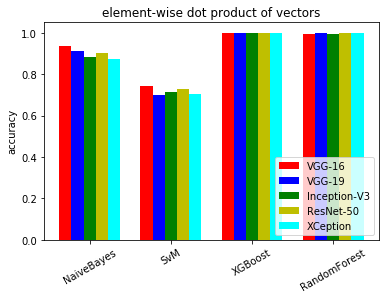

In [16]:
#In [31]:
scores
#In [32]:
width=0.15
plt.bar(np.arange(NUM_CLASSIFIERS), scores[0], width, color="r", label="VGG-16")
plt.bar(np.arange(NUM_CLASSIFIERS)+width, scores[1], width, color="b", label="VGG-19")
plt.bar(np.arange(NUM_CLASSIFIERS)+2*width, scores[2], width, color="g", label="Inception-V3")
plt.bar(np.arange(NUM_CLASSIFIERS)+3*width, scores[3], width, color="y", label="ResNet-50")
plt.bar(np.arange(NUM_CLASSIFIERS)+4*width, scores[4], width, color="cyan", label="XCeption")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xticks(np.arange(NUM_CLASSIFIERS)+2*width, ["NaiveBayes", "SvM", "XGBoost", "RandomForest"],
          rotation=30)
plt.title("element-wise dot product of vectors")